# Comp pipeline viz
In this notebook, we aim to generate example images demonstrating the cellular profiling pipeline (segmentation, filtering and cell type annotation).  
For this, we need the raw images and pre-filtered tables (similar to the actual filtering script), as well as the filtered segmentation masks and the corresponding cell type annotations.

## Load Python libraries

In [1]:
import os
import pandas as pd
from plotnine import *

## Set up BioProfiling.jl

In [2]:
# Just ignore the scary error
from julia.api import Julia
jl = Julia(compiled_modules=False)
from julia import DataFrames, Main
import julia.BioProfiling as bp

┌ Error: Error during loading of extension AdaptStaticArraysExt of Adapt, use `Base.retry_load_extensions()` to retry.
│   exception =
│    1-element ExceptionStack:
│    LoadError: ArgumentError: Package AdaptStaticArraysCoreExt does not have Adapt in its dependencies:
│    - You may have a partially installed environment. Try `Pkg.instantiate()`
│      to ensure all packages in the environment are installed.
│    - Or, if you have AdaptStaticArraysCoreExt checked out for development and have
│      added Adapt as a dependency but haven't updated your primary
│      environment's manifest file, try `Pkg.resolve()`.
│    - Otherwise you may need to report an issue with AdaptStaticArraysCoreExt
│    Stacktrace:
│      [1] macro expansion
│        @ ./loading.jl:1634 [inlined]
│      [2] macro expansion
│        @ ./lock.jl:267 [inlined]
│      [3] require(into::Module, mod::Symbol)
│        @ Base ./loading.jl:1611
│      [4] include
│        @ ./Base.jl:457 [inlined]
│      [5] _requir

In [3]:
%load_ext julia.magic

Initializing Julia interpreter. This may take some time...


<PyCall.jlwrap union>

In [6]:
%%julia 
using DataFrames, BioProfiling, PyCall
function pd_to_df(df_pd)
    df= DataFrame()
    for col in df_pd.columns
        df[!, col] = getproperty(df_pd, col).values
        if eltype(df[:, col]) == PyObject
            # Strings are not automatically converted
            df[!, col] = PyCall.py"list($df_pd[$col])"
        end
    end
    return(df)
end

<PyCall.jlwrap pd_to_df>

In [7]:
%%julia
PyCall.py"""
class SymStr():
    def __init__(self, *args, **kwargs):
        self.s = str(*args, **kwargs)
    def __str__(self):
        return self.s.__str__()
    def __repr__(self):
        return f'SymStr("{self.__str__()}")'
"""

sym_str_py_type = PyCall.py"SymStr";

PyCall.PyObject( s :: Symbol ) = PyCall.py"SymStr($(string(s)))"o
function PyCall.convert( ::Type{Symbol}, po :: PyCall.PyObject ) 
    sym_str = PyCall.pyisinstance( po, sym_str_py_type ) ? po.s : po;
    return Symbol(PyCall.convert(AbstractString, sym_str))
end
PyCall.pytype_mapping(sym_str_py_type, Symbol)
nothing

## Load data

In [49]:
# Intensity per cells from cellpose segmentation
fov = "A1f"
markers = pd.read_csv(f"/data/{fov}_cell_table.csv",
                      index_col=0)
markers["fov"] = fov

In [50]:
markers["url"] = [f"/data/{fov}/nuclei_clahe.tiff" for fov in markers.fov]

In [51]:
# Used by BioProfiling to describe center of cells
markers["AreaShape_Center_X"] = markers["centroid-1"]
markers["AreaShape_Center_X_1"] = markers["centroid-1"]
markers["AreaShape_Center_Y"] = markers["centroid-0"]
markers["AreaShape_Center_Y_1"] = markers["centroid-0"]

In [52]:
markers["NuclearIntensity"] = markers.area * markers["nuclei_clahe.tiff"]

In [53]:
# Let BioProfiling.jl handle the rest
xp = bp.Experiment(Main.pd_to_df(markers))

In [54]:
# Which markers do we want to compare? 
cols_to_discard = ["chan_39.tiff", 
                        "chan_48.tiff", 
                        "chan_69.tiff", 
                        "chan_71.tiff",
                        "Fe.tiff",
                        "Noodle.tiff",
                        "ASCT2_clahe.tiff",
                        "membrane.tiff",
                        "Au.tiff",
                        "membrane_clahe.tiff",
                        "GLUT1_clahe.tiff",
                        "nuclei_clahe.tiff"]
filters = [bp.NameSelector(lambda ft : ft not in cols_to_discard)]

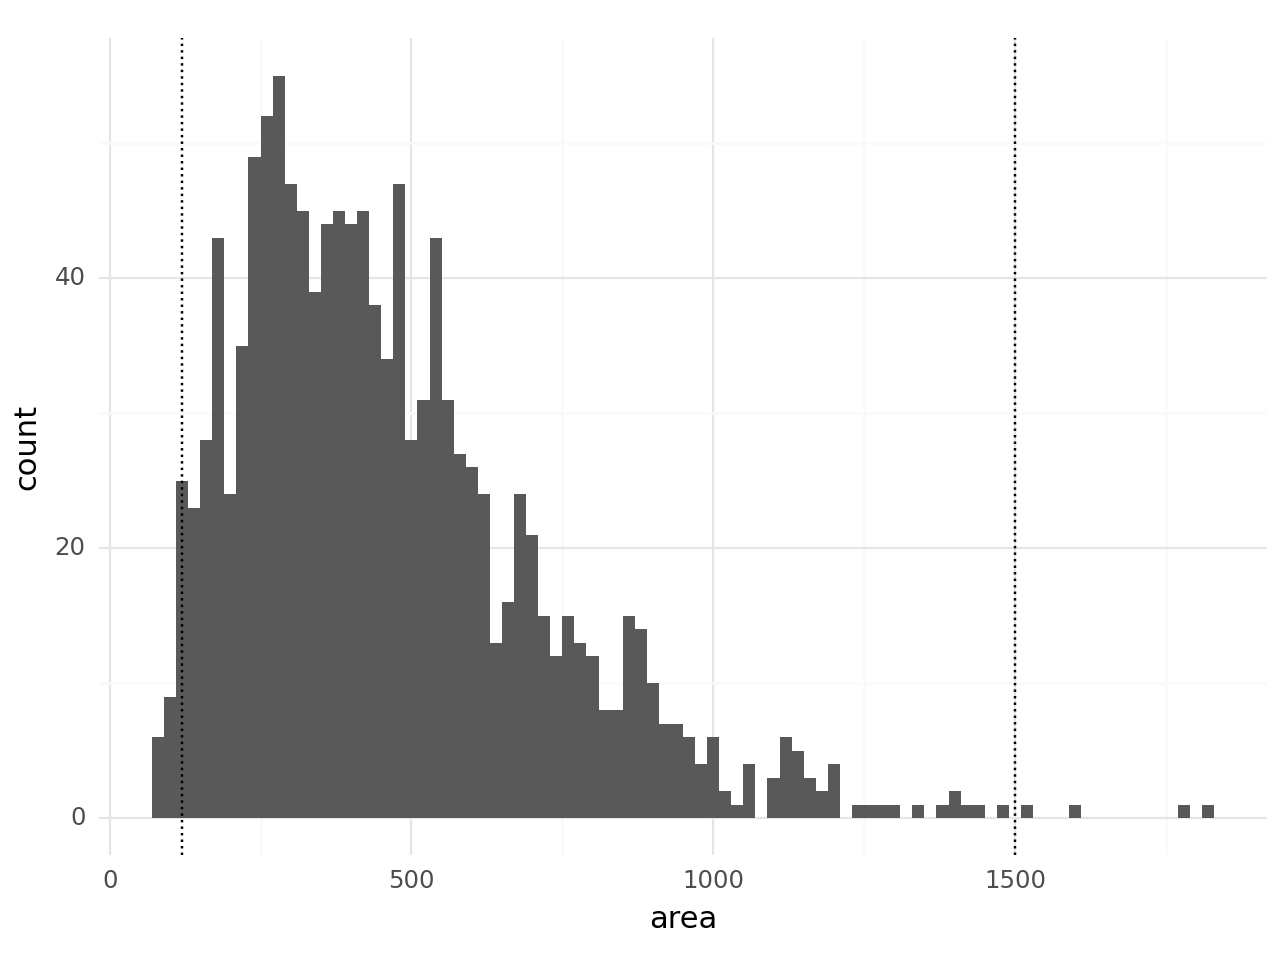

<Figure Size: (640 x 480)>

In [55]:
ggplot(markers, aes(x = 'area')) +\
    geom_histogram(binwidth = 20) +\
    geom_vline(xintercept = 120, linetype = "dotted") +\
    geom_vline(xintercept = 1500, linetype = "dotted") +\
    theme_minimal()

In [56]:
# We define a filter to be used by BioProfiling
filters.append(jl.eval("Filter(120, :area, compare = >)"))

# We want to keep cells large enough, but we want to visualize the ones that are excluded
# so we define an "inverse filter"
negf1 = bp.negation(filters[-1])

In [57]:
# Same for maximum size, this is an equivalent syntax
filters.append(bp.Filter(1500, Main.Symbol("area"), 
                         compare = lambda a, b: a < b))
# Which cells are excluded?
negf2 = bp.negation(filters[-1])

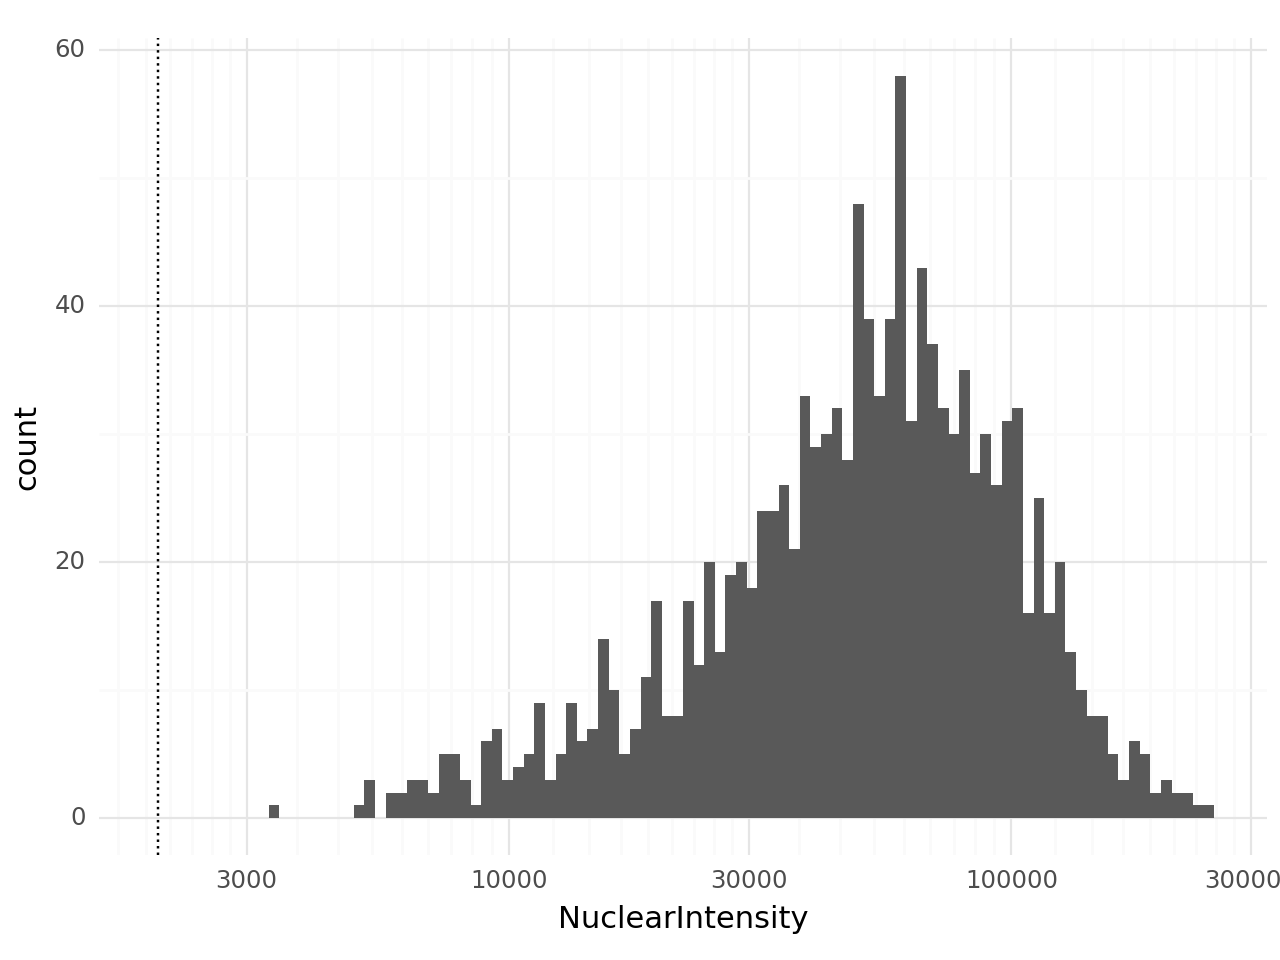

<Figure Size: (640 x 480)>

In [58]:
ggplot(markers, aes(x = 'NuclearIntensity')) +\
    geom_histogram(bins = 100) +\
    scale_x_log10() +\
    geom_vline(xintercept = 2e3, linetype = "dotted") +\
    theme_minimal()

In [59]:
filters.append(bp.Filter(2e3, 
                         Main.Symbol("NuclearIntensity"), 
                         compare = lambda a, b: a > b))
# Which cells are excluded?
negf4 = bp.negation(filters[-1])

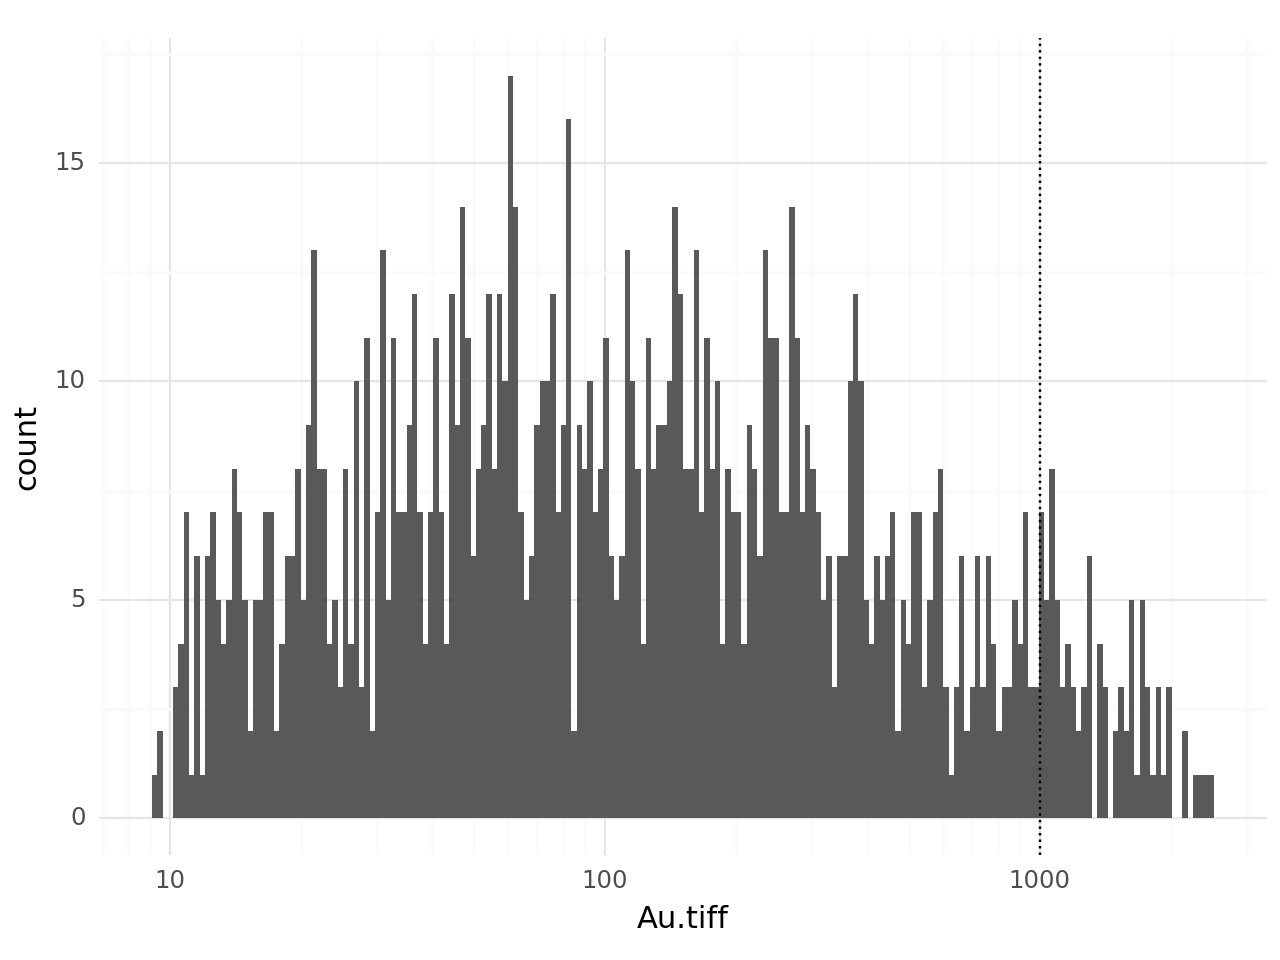

<Figure Size: (640 x 480)>

In [60]:
ggplot(markers, aes(x = 'Au.tiff')) +\
    geom_histogram(bins = 200) +\
    scale_x_log10() +\
    geom_vline(xintercept = 1000, linetype = "dotted") +\
    theme_minimal()

In [61]:
filters.append(bp.Filter(1000, 
                         Main.Symbol("Au.tiff"), 
                         compare = lambda a, b: a < b))
# Which cells are excluded?
negf5 = bp.negation(filters[-1])

Image 1: size-filtered cells

In [62]:
disp_filt1 = bp.CombinationFilter(negf1, negf2, Main.union)

In [64]:
%%julia

# Folder where the filtered cell images will be stored
filterfolder = "./manuscript_images/"

# Define the substitution for channel paths
rgbrgx = [["nuclei_clahe" => "black"], ["nuclei_clahe" => "membrane_clahe"], []]

# Access Python objects
xp = py"xp"
disp_filt1 = py"disp_filt1"
fov = py"fov"

# If something is filtered out
if !isempty(filter_entries(xp, disp_filt1))
    diagnostic_images(xp, disp_filt1, :url,
                        path = filterfolder,
                        rgb = rgbrgx,
                        center = true,
                        show = false, saveimages = true, 
                        savelimit = 1, # How many example images do you want?
                        keepsubfolders = 1)

    # Move filtered image to keep individual filters separate
    mv(joinpath(filterfolder, string(fov), "nuclei_clahe.tiff"), 
        joinpath(filterfolder, string(fov), "size_filter.tiff"),
        force=true)
end

'./manuscript_images/A1f/size_filter.tiff'

Image 2: gold-filtered cells

In [65]:
%%julia

# Folder where the filtered cell images will be stored
filterfolder = "./manuscript_images/"

# Define the substitution for channel paths
rgbrgx = [["nuclei_clahe" => "Au_16"], ["nuclei_clahe" => "Au_16"], []]

# Access Python objects
xp = py"xp"
disp_filt1 = py"negf5"
fov = py"fov"

# If something is filtered out
if !isempty(filter_entries(xp, disp_filt1))
    diagnostic_images(xp, disp_filt1, :url,
                        path = filterfolder,
                        rgb = rgbrgx,
                        center = true,
                        show = false, saveimages = true, 
                        savelimit = 1, # How many example images do you want?
                        keepsubfolders = 1)

    # Move filtered image to keep individual filters separate
    mv(joinpath(filterfolder, string(fov), "nuclei_clahe.tiff"), 
        joinpath(filterfolder, string(fov), "gold_filter.tiff"),
        force=true)
end

'./manuscript_images/A1f/gold_filter.tiff'

## Cell type annotation example

In [96]:
import pandas as pd
import numpy as np
from collections import defaultdict
from skimage import io

In [74]:
# Fov to annotation
fov = "A3o"

In [83]:
# Load cell type annotation
annot = pd.read_csv("/data/annotation_consensus.csv", header = None)
annot = annot.loc[annot[0] == fov, 1:]

In [84]:
# Load cell masks
cell_masks = io.imread(f"/data/{fov}/segmentation_filtered.tiff")

In [97]:
# Define a cell type to color mapping
cell_type_to_color = defaultdict(lambda: (255, 0, 255)) # Default to immune color
cell_type_to_color["Unclear"] = [200, 200, 200]
cell_type_to_color["CAF"] = [0, 255, 0]
cell_type_to_color["Cancer_cell"] = [255, 255, 0]
cell_type_to_color["Endothelial_cell"] = [0, 255, 255]

In [102]:
# Cell IDs should match
assert np.max(cell_masks) == annot[1].max()

# We go from a grey-scale image to a RGB image
annotated_masks = np.zeros((cell_masks.shape[0], cell_masks.shape[1], 3), dtype = np.uint8)

# For each pixel 
for i in range(annotated_masks.shape[0]):
    for j in range(annotated_masks.shape[1]):
        cell_id = cell_masks[i, j]
        if cell_id != 0:
            cell_type = annot.loc[annot[1] == cell_id, 2].values[0]
            annotated_masks[i, j] = cell_type_to_color[cell_type]

In [105]:
io.imsave(f"./manuscript_images/{fov}/annotation.tiff", annotated_masks)